# AB-тест для посадочной страницы

## Описание

Компания разработала новую посадочную страницу с целью увеличения продаж своего продукта. Было решено провести А/Б-тестирование, чтобы узнать, какая из версий посадочной страницы покажет себя лучше. Пользователей собрали в две группы одинакового размера. Экспериментальной группе (treatment group) была показана новая посадочная страница, контрольной группе (control group) - старая

### Какие данные представлены?

user_id: уинкальный идентификатор пользователя
timestamp: время посещения страницы
group: группа (экспериментальная или контрольная)
landing_page: посадочная страница (старая - old_page либо новая - new_page)
converted: статус пользователя после просмотра страницы (1 - совершил покупку, 0 - нет)

In [37]:
#все библиотеки 
import pandas as pd
import numpy as np
import scipy.stats as stats
from IPython.display import Image, display
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from tqdm.autonotebook import tqdm

/var/folders/tg/9wjldqyd6jx2gyw4jp24xqr40000gp/T/ipykernel_26026/2783672785.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Препроцессинг 

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
print(f'Размер датасета: {df.shape[0]} строк и {df.shape[1]} столбцов.')

Размер датасета: 294480 строк и 5 столбцов.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [11]:
print(f"Число пропусков в данных:\n{df.isnull().sum()}")

Число пропусков в данных:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [14]:
print(f"Число повторяющихся наблюдений: {df.duplicated().sum()}")

Число повторяющихся наблюдений: 0


In [15]:
#число уникальных значений в каждом столбце
df.nunique()

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

Есть ли повторяющиеся идентификаторы пользователей?

In [16]:
df[df['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,13:42.6,control,old_page,0
2893,773192,55:59.6,treatment,new_page,0
7500,899953,06:54.1,control,new_page,0
8036,790934,32:20.3,treatment,new_page,0
10218,633793,16:00.7,treatment,old_page,0
...,...,...,...,...,...
294309,787083,15:21.0,control,old_page,0
294328,641570,59:27.7,control,old_page,0
294331,689637,34:28.3,control,new_page,0
294355,744456,32:07.1,treatment,new_page,0


Есть ли в данных записи с несоответствиями в колонках group и landing_page?
Группе treatment должна была показываться новая посадочная страница, группе control - старая.

In [17]:
df_mismatch_in_treatment = df[(df['group']=='treatment') & (df['landing_page']=='old_page')]

df_mismatch_in_control = df[(df['group']=='control') & (df['landing_page']=='new_page')]

n_mismatch = df_mismatch_in_treatment.shape[0] + df_mismatch_in_control.shape[0]

print(f'Сколько раз экспериментальной группе была показана старая посадочная страница: {df_mismatch_in_treatment.shape[0]}')
print(f'Сколько раз контрольной группе была показана новая посадочная страница: {df_mismatch_in_control.shape[0]}')
print(f'Общее число ошибок: {n_mismatch}')

Сколько раз экспериментальной группе была показана старая посадочная страница: 1965
Сколько раз контрольной группе была показана новая посадочная страница: 1928
Общее число ошибок: 3893


По каким-то причинам некоторым пользователям была показана неправильная посадочная страница. Исключим таких пользователей из исследования.

In [18]:
df_cleaned = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page") | (df["group"]=="control")&(df["landing_page"]=="old_page")]
df_cleaned.shape

(290587, 5)

В данных остается еще два дубликата. Данные дубликаты появились из-за повторного посещения пользователями посадочной страницы.

In [19]:
df_cleaned[df_cleaned['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [21]:
df_cleaned[df_cleaned['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


In [22]:
df_cleaned[df_cleaned['user_id'] == 759899]

,user_id,timestamp,group,landing_page,converted
250001,759899,07:36.1,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


## Доверительный интервал 

Сравним проценты конверсии для групп

In [23]:
conv = df_cleaned.groupby('landing_page')['converted'].agg(['count', 'mean']).reset_index()
conv['mean'] = conv['mean'] * 100
conv

,landing_page,count,mean
0,new_page,145313,11.880561
1,old_page,145274,12.038630


Кажется, есть небольшое ухудшение в конверсии пользователей, которым показывалась новая посадочная страница. Для старой посадочной страницы конверсия - 12%, для новой 11,8%. Хочется узнать, значима ли эта разница?

Построим 95%-й доверительный интервал для разницы долей.

In [26]:
x = df_cleaned[df_cleaned.landing_page == 'new_page'].converted.values
y = df_cleaned[df_cleaned.landing_page == 'old_page'].converted.values

diff = x.mean() - y.mean() # разница средних
nx, ny = x.size, y.size # размеры долей
diff_std = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx) # стандартное отклонение долей

left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
print(f'Доверительный интервал [{round(left, 5)}; {round(right, 5)}] ширины {round(right-left, 5)}')

Доверительный интервал [-0.00394; 0.00078] ширины 0.00472


Ноль входит в доверительный интервал, поэтому на уровне значимости 5% можно сделать вывод о том, что изменения не значимы.

Проверим гипотезу о равенстве средних, используя z-критерий.

Нулевая гипотеза H0: Средние не отличаются.

Альтернативная гипотеза H1: Существуют различия в средних значениях.

In [27]:
alpha = 0.05

z_obs = diff/diff_std # наблюдаемое значение z-критерия
z_crit = stats.norm.ppf(1 - alpha/2) # критическое значение z-критерия

print(f'{z_obs:.3} попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза НЕ отвергается')

-1.31 попадает в (-1.96 , 1.96) => Нулевая гипотеза НЕ отвергается


Наблюдаемое значение z-критерия попадает в критический интервал, значит на уровне значимости 5% можно сделать вывод о том, что изменения не значимы.

Зная наблюдаемое значение z-критерия, посчитаем p-уровень значимости.

In [28]:
print(f'p-уровень значимости = {2 * (1 - stats.norm().cdf(np.abs(z_obs)))}')

p-уровень значимости = 0.1891623336124968


p-уровень значимости больше 0.05, что также не позволяет отклонить гипотезу о равенстве средних.

## Критерий хи-квадрат Пирсона

Мы можем оценить значимость различий между двумя группами, используя критерий хи-квадрат Пирсона. Для начала построим таблицу сопряженности.

Посмотрим на количество и процент пользователей, совершивших покупку и не совершивших покупку, отдельно в контрольной и экспериментальной группах.

In [29]:
df_counts = pd.DataFrame({'Кол-во в контр. группе': df_cleaned[df_cleaned.group=='control'].converted.value_counts(),
              'Кол-во в эксп. группе': df_cleaned[df_cleaned.group=='treatment'].converted.value_counts(),
              '% в контр. группе': df_cleaned[df_cleaned.group=='control'].converted.value_counts()/ len(df_cleaned[df_cleaned.group=='control']),
              '% в эксп. группе': df_cleaned[df_cleaned.group=='treatment'].converted.value_counts() / len(df_cleaned[df_cleaned.group=='treatment'])})
df_counts

,Кол-во в контр. группе,Кол-во в эксп. группе,% в контр. группе,% в эксп. группе
converted,,,,
0,127785,128049,0.879614,0.881194
1,17489,17264,0.120386,0.118806


In [ ]:
Для исследования возьмем из таблицы первые две колонки с количеством пользователей.

In [30]:
count_table = df_counts.iloc[:,0:2].to_numpy()
count_table

array([[127785, 128049],
       [ 17489,  17264]])

Нулевая гипотеза H0: Распределение не отличается от ожидаемого.

Альтернативная гипотеза H1: Распределение отличается (существует статистически значимая разница между конверсиями в зависимости от версии посадочной страницы).

In [32]:
stat, p, dof, expected = stats.chi2_contingency(count_table) # результаты теста
print(f'Число степеней свободы: {dof}')
print('#######################################', '\n')

print('Ожидаемое распределение: ')
print(expected)
print('#######################################', '\n')

prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print(f'Критическое значение статистики: {round(critical, 2)}')
print(f'Полученное значение статистики: {round(stat, 2)}')
print('#######################################', '\n')

alpha = 1-prob
print(f'Критическое значение p-уровня значимости: {round(alpha, 2)}')
print(f'Полученное значение p-уровня значимости: {round(p, 2)}')
print('#######################################', '\n')

Число степеней свободы: 1
####################################### 

Ожидаемое распределение: 
[[127899.83211912 127934.16788088]
 [ 17374.16788088  17378.83211912]]
####################################### 

Критическое значение статистики: 3.84
Полученное значение статистики: 1.71
####################################### 

Критическое значение p-уровня значимости: 0.05
Полученное значение p-уровня значимости: 0.19
####################################### 



Наблюдаемое значение p-уровня значимости больше критического значения, поэтому можно сделать вывод, что статистически значимой разницы между конверсиями нет.

##  Бутстрэп

Сделаем 10000 бутстрэп выборок и посчитаем средние значения конверсии по каждой версии посадочной страницы. Затем посмотрим на распределние средних.

In [38]:
boot_1d = []
for i in tqdm(range(10000), leave=False):
    boot_mean = df_cleaned.sample(frac=1, replace=True).groupby('landing_page').converted.mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)

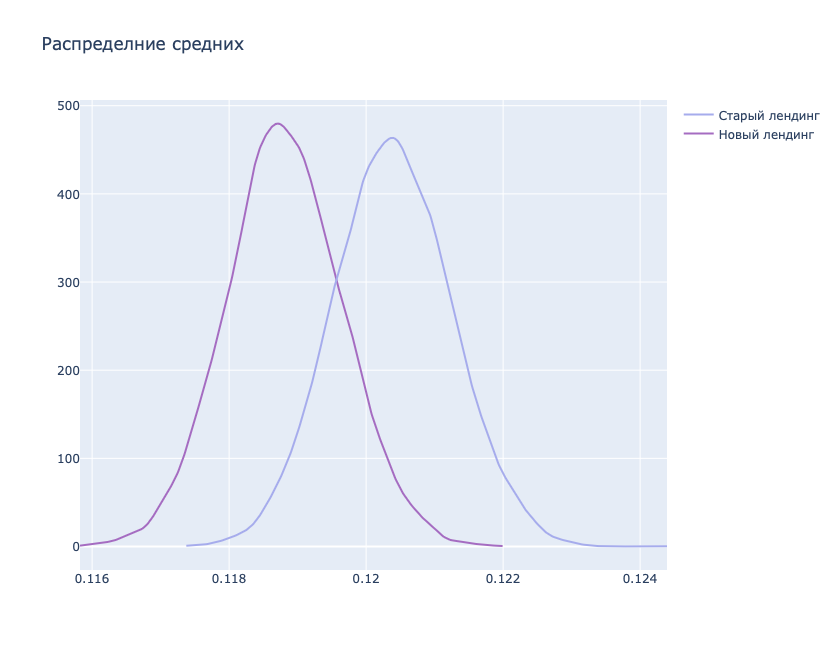

In [41]:
hist_data = [boot_1d.new_page, boot_1d.old_page]

group_labels = ['Новый лендинг', 'Старый лендинг']
colors = ['#A56CC1', '#A6ACEC']

fig = ff.create_distplot(hist_data, group_labels, colors=colors, show_hist=False, bin_size=.01, show_rug=False)

fig.update_layout(height=650, width=1000, title_text='Распределние средних')
fig.show()

Для обеих версий посадочной страницы мы получили распределение, похожее на нормальное.

В колонке diff посчитаем разницу между средними и посмотрим на распределение.

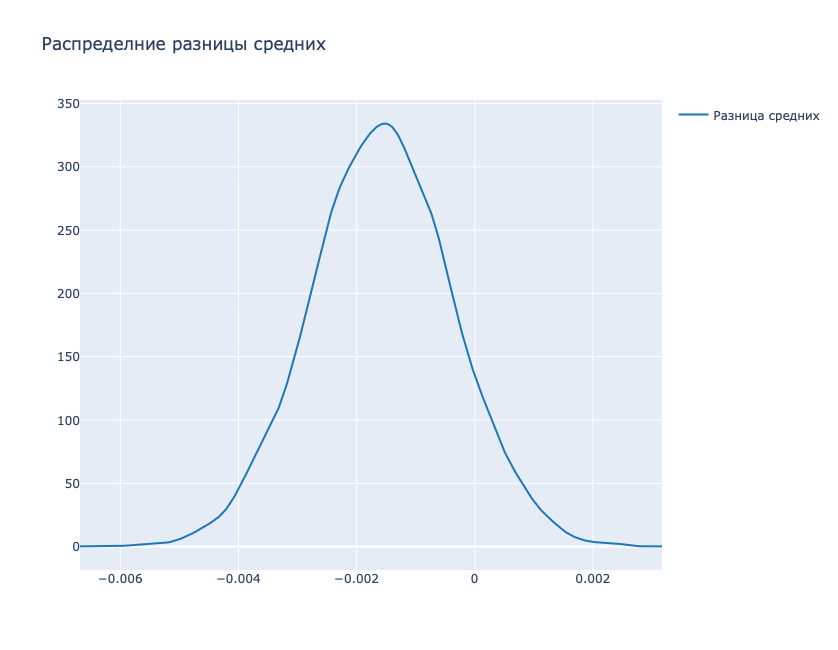

In [42]:
boot_1d['diff'] = boot_1d.new_page-boot_1d.old_page

hist_data = [list(boot_1d['diff'])]
group_labels = ['Разница средних']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, bin_size=.01, show_rug=False)

fig.update_layout(height=650, width=1000, title_text='Распределние разницы средних')
fig.show()


In [ ]:
Посчитаем 95%-й доверительный интервал для разницы средних.

In [43]:
alpha=0.05

left = np.quantile(boot_1d['diff'], alpha/2)
right = np.quantile(boot_1d['diff'], 1-alpha/2)

print(left, right)

-0.003913549473393928 0.0007873280463671311


Ноль попадает в доверительный интервал, значит на уровне значимости 5% разницы между исследуемыми группами нет. Изменения в конверсии можно считать статистически не значимыми.

## Результаты исследования: Влияние нового дизайна посадочной страницы на конверсию

### 1. **Доверительный интервал**
Для оценки разницы средних значений конверсии был построен 95%-й доверительный интервал. На уровне значимости 5% результаты показали, что разница между конверсиями в группах не является статистически значимой. Это позволяет заключить, что новый дизайн не оказывает влияния на конверсию пользователей.

### 2. **Критерий хи-квадрат Пирсона**
Применив критерий хи-квадрат Пирсона, был получен p-уровень значимости, который оказался больше критического значения (p > 0.05). Это также подтверждает отсутствие статистически значимой разницы между конверсиями в исследуемых группах.

### 3. **Бутстрэп метод**
После применения метода бутстрэпа к данным о конверсиях пользователей результаты показали, что на уровне значимости 5% различий между группами нет. Это подтверждает выводы предыдущих анализов.

### **Заключение**
Исходя из проведённых статистических тестов, можно утверждать, что изменение дизайна посадочной страницы не оказывает значимого влияния на конверсию пользователей.